In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow

import lib.config.config as cfg
from lib.datasets import roidb as rdl_roidb
from lib.datasets.factory import get_imdb
from lib.datasets.imdb import imdb as imdb2
from lib.layer_utils.roi_data_layer import RoIDataLayer
from lib.nets.vgg16rgb import vgg16
from lib.utils.timer import Timer

tf.app.flags.DEFINE_string('f', '', 'kernel')
try:
    import cPickle as pickle
except ImportError:
    import pickle
import os


def get_training_roidb(imdb):
    """Returns a roidb (Region of Interest database) for use in training."""
    if True:
        print('Appending horizontally-flipped training examples...')
        imdb.append_flipped_images()
        print('done')

    print('Preparing training data...')
    rdl_roidb.prepare_roidb(imdb)
    print('done')

    return imdb.roidb


def combined_roidb(imdb_names):
    """
    Combine multiple roidbs
    """

    def get_roidb(imdb_name):
        imdb = get_imdb(imdb_name)
        print('Loaded dataset `{:s}` for training'.format(imdb.name))
        imdb.set_proposal_method("gt")
        print('Set proposal method: {:s}'.format("gt"))
        roidb = get_training_roidb(imdb)
        return roidb

    roidbs = [get_roidb(s) for s in imdb_names.split('+')]
    roidb = roidbs[0]
    if len(roidbs) > 1:
        for r in roidbs[1:]:
            roidb.extend(r)
        tmp = get_imdb(imdb_names.split('+')[1])
        imdb = imdb2(imdb_names, tmp.classes)
    else:
        imdb = get_imdb(imdb_names)
    return imdb, roidb


class Train:
    def __init__(self):

        # Create network
        if cfg.FLAGS.net == 'vgg16':
            self.net = vgg16(batch_size=cfg.FLAGS.ims_per_batch)
        else:
            raise NotImplementedError

        self.imdb, self.roidb = combined_roidb("DIY_dataset")

        self.data_layer = RoIDataLayer(self.roidb, self.imdb.num_classes)
        self.output_dir = cfg.get_output_dir(self.imdb, 'default')

    def train(self):

        # Create session
        tfconfig = tf.ConfigProto(allow_soft_placement=True)  # allow_soft_placement = true : select GPU automatically
        tfconfig.gpu_options.allow_growth = True
        # tfconfig.gpu_options.per_process_gpu_memory_fraction = 0.90
        sess = tf.Session(config=tfconfig)

        with sess.graph.as_default():

            tf.set_random_seed(cfg.FLAGS.rng_seed)
            layers = self.net.create_architecture(sess, "TRAIN", self.imdb.num_classes, tag='default')
            loss = layers['total_loss']
            lr = tf.Variable(cfg.FLAGS.learning_rate, trainable=False)
            momentum = cfg.FLAGS.momentum
            optimizer = tf.train.MomentumOptimizer(lr, momentum)

            gvs = optimizer.compute_gradients(loss)

            # Double bias
            # Double the gradient of the bias if set
            if cfg.FLAGS.double_bias:
                final_gvs = []
                with tf.variable_scope('Gradient_Mult'):
                    for grad, var in gvs:
                        scale = 1.
                        if cfg.FLAGS.double_bias and '/biases:' in var.name:
                            scale *= 2.
                        if not np.allclose(scale, 1.0):
                            grad = tf.multiply(grad, scale)
                        final_gvs.append((grad, var))
                train_op = optimizer.apply_gradients(final_gvs)
            else:
                train_op = optimizer.apply_gradients(gvs)

            # We will handle the snapshots ourselves
            self.saver = tf.train.Saver(max_to_keep=100000)
            # Write the train and validation information to tensorboard
            writer = tf.summary.FileWriter('default/', sess.graph)
            # valwriter = tf.summary.FileWriter(self.tbvaldir)

        # Load weights
        # Fresh train directly from ImageNet weights
        print('Loading initial model weights from {:s}'.format(cfg.FLAGS.pretrained_model))
        variables = tf.global_variables()
        # Initialize all variables first
        sess.run(tf.variables_initializer(variables, name='init'))
        var_keep_dic = self.get_variables_in_checkpoint_file(cfg.FLAGS.pretrained_model)
        # Get the variables to restore, ignorizing the variables to fix
        variables_to_restore = self.net.get_variables_to_restore(variables, var_keep_dic, sess,
                                                                 cfg.FLAGS.pretrained_model)

        restorer = tf.train.Saver(variables_to_restore)
        restorer.restore(sess, cfg.FLAGS.pretrained_model)
        print('Loaded.')
        # Need to fix the variables before loading, so that the RGB weights are changed to BGR
        # For VGG16 it also changes the convolutional weights fc6 and fc7 to
        # fully connected weights
        self.net.fix_variables(sess, cfg.FLAGS.pretrained_model)
        print('Fixed.')
        sess.run(tf.assign(lr, cfg.FLAGS.learning_rate))
        last_snapshot_iter = 0

        timer = Timer()
        iter = last_snapshot_iter + 1
        last_summary_time = time.time()
        print('START TRAINING: ...')
        while iter < cfg.FLAGS.max_iters + 1:
            # Learning rate
            if iter == cfg.FLAGS.step_size + 1:
                # Add snapshot here before reducing the learning rate
                # self.snapshot(sess, iter)
                sess.run(tf.assign(lr, cfg.FLAGS.learning_rate * cfg.FLAGS.gamma))

            timer.tic()
            # Get training data, one batch at a time
            blobs = self.data_layer.forward()
            iter += 1
            # Compute the graph without summary
            if iter % 100 == 0:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss, summary = self.net.train_step_with_summary(
                    sess, blobs, train_op)
                timer.toc()

                run_metadata = tf.RunMetadata()
                writer.add_run_metadata(run_metadata, 'step%03d' % iter)
                writer.add_summary(summary, iter)
            else:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss = self.net.train_step(
                    sess, blobs, train_op)
                timer.toc()

            # Display training information
            if iter % (cfg.FLAGS.display) == 0:
                print('iter: %d / %d, total loss: %.6f\n >>> rpn_loss_cls: %.6f\n '
                      '>>> rpn_loss_box: %.6f\n >>> loss_cls: %.6f\n >>> loss_box: %.6f\n ' % \
                      (iter, cfg.FLAGS.max_iters, total_loss, rpn_loss_cls, rpn_loss_box, loss_cls, loss_box))
                print('speed: {:.3f}s / iter'.format(timer.average_time))

            if iter % cfg.FLAGS.snapshot_iterations == 0:
                self.snapshot(sess, iter)

    def get_variables_in_checkpoint_file(self, file_name):
        try:
            reader = pywrap_tensorflow.NewCheckpointReader(file_name)
            var_to_shape_map = reader.get_variable_to_shape_map()
            return var_to_shape_map
        except Exception as e:  # pylint: disable=broad-except
            print(str(e))
            if "corrupted compressed block contents" in str(e):
                print("It's likely that your checkpoint file has been compressed "
                      "with SNAPPY.")

    def snapshot(self, sess, iter):
        net = self.net

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Store the model snapshot
        filename = 'vgg16_faster_rcnn_rgb_iter_{:d}'.format(iter) + '.ckpt'
        filename = os.path.join(self.output_dir, filename)
        self.saver.save(sess, filename)
        print('Wrote snapshot to: {:s}'.format(filename))

        # Also store some meta information, random state, etc.
        nfilename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.pkl'
        nfilename = os.path.join(self.output_dir, nfilename)
        # current state of numpy random
        st0 = np.random.get_state()
        # current position in the database
        cur = self.data_layer._cur
        # current shuffled indeces of the database
        perm = self.data_layer._perm

        # Dump the meta info
        with open(nfilename, 'wb') as fid:
            pickle.dump(st0, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(cur, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(perm, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(iter, fid, pickle.HIGHEST_PROTOCOL)

        return filename, nfilename


if __name__ == '__main__':
    train = Train()
    train.train()


Loaded dataset `DIY_dataset` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
DIY_dataset gt roidb loaded from /home/jovyan/TensorRGBNet/Image_manipulation_detection-master/data/cache/DIY_dataset_gt_roidb.pkl
done
Preparing training data...
done


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading initial model weights from ./data/imagenet_weights/vgg16.ckpt
Variables restored: vgg_16/conv1/conv1_1/biases:0
Variables restored: vgg_16/conv1/conv1_2/weights:0
Variables restored: vgg_16/conv1/conv1_2/biases:0
Variables restored: vgg_16/conv2/conv2_1/weights:0
Variables restored: vgg_16/conv2/conv2_1/biases:0
Variables restored: vgg_16/conv2/conv2_2/weights:0
Variables restored: vgg_16/conv2/conv2_2/biases:0
Variables restored: vgg_16/conv3/conv3_1/weights:0
Variables restored: vgg_16/conv3/conv3_1/biases:0
Variables restored: vgg_16/conv3/conv3_2/weights:0
Variables restored: vgg_16/conv3/conv3_2/biases:0
Variables restored: vgg_16/conv3/conv3_3/weights:0
Variables restored: vgg_16/conv3/conv3_3/biases:0
Variables restored: vgg_16/conv4/conv4_1/weights:0
Variables restored: vgg_16/conv4/conv4_1/biases:0
Variables restored: vgg_16/conv4/conv4_2/weights:0
Variables restored: vgg_16/conv4/conv4_2/biases:0
Variables restored: vgg_16/conv4/conv4_3/weights:0
Variables restored: v

iter: 410 / 4001, total loss: 0.639827
 >>> rpn_loss_cls: 0.171090
 >>> rpn_loss_box: 0.032922
 >>> loss_cls: 0.201910
 >>> loss_box: 0.233906
 
speed: 4.578s / iter
iter: 420 / 4001, total loss: 0.374662
 >>> rpn_loss_cls: 0.078148
 >>> rpn_loss_box: 0.003046
 >>> loss_cls: 0.143367
 >>> loss_box: 0.150101
 
speed: 4.583s / iter
iter: 430 / 4001, total loss: 0.221408
 >>> rpn_loss_cls: 0.098197
 >>> rpn_loss_box: 0.034430
 >>> loss_cls: 0.088781
 >>> loss_box: 0.000000
 
speed: 4.591s / iter
iter: 440 / 4001, total loss: 1.011464
 >>> rpn_loss_cls: 0.072195
 >>> rpn_loss_box: 0.009906
 >>> loss_cls: 0.374717
 >>> loss_box: 0.554647
 
speed: 4.600s / iter
iter: 450 / 4001, total loss: 0.390713
 >>> rpn_loss_cls: 0.109659
 >>> rpn_loss_box: 0.007386
 >>> loss_cls: 0.177398
 >>> loss_box: 0.096270
 
speed: 4.598s / iter
iter: 460 / 4001, total loss: 0.407830
 >>> rpn_loss_cls: 0.109321
 >>> rpn_loss_box: 0.006620
 >>> loss_cls: 0.142951
 >>> loss_box: 0.148938
 
speed: 4.602s / iter
iter

iter: 910 / 4001, total loss: 0.214460
 >>> rpn_loss_cls: 0.082899
 >>> rpn_loss_box: 0.012255
 >>> loss_cls: 0.064624
 >>> loss_box: 0.054682
 
speed: 4.952s / iter
iter: 920 / 4001, total loss: 0.497758
 >>> rpn_loss_cls: 0.148618
 >>> rpn_loss_box: 0.006312
 >>> loss_cls: 0.170375
 >>> loss_box: 0.172453
 
speed: 4.958s / iter
iter: 930 / 4001, total loss: 0.568515
 >>> rpn_loss_cls: 0.065859
 >>> rpn_loss_box: 0.005934
 >>> loss_cls: 0.204644
 >>> loss_box: 0.292079
 
speed: 4.968s / iter
iter: 940 / 4001, total loss: 0.193654
 >>> rpn_loss_cls: 0.146755
 >>> rpn_loss_box: 0.033884
 >>> loss_cls: 0.013015
 >>> loss_box: 0.000000
 
speed: 4.983s / iter
iter: 950 / 4001, total loss: 0.561130
 >>> rpn_loss_cls: 0.179656
 >>> rpn_loss_box: 0.053012
 >>> loss_cls: 0.143544
 >>> loss_box: 0.184917
 
speed: 4.992s / iter
iter: 960 / 4001, total loss: 0.212094
 >>> rpn_loss_cls: 0.055377
 >>> rpn_loss_box: 0.005396
 >>> loss_cls: 0.087229
 >>> loss_box: 0.064092
 
speed: 5.008s / iter
iter

iter: 1400 / 4001, total loss: 0.431095
 >>> rpn_loss_cls: 0.055460
 >>> rpn_loss_box: 0.002855
 >>> loss_cls: 0.198199
 >>> loss_box: 0.174581
 
speed: 5.041s / iter
iter: 1410 / 4001, total loss: 0.291206
 >>> rpn_loss_cls: 0.256381
 >>> rpn_loss_box: 0.023889
 >>> loss_cls: 0.010936
 >>> loss_box: 0.000000
 
speed: 5.040s / iter
iter: 1420 / 4001, total loss: 0.448346
 >>> rpn_loss_cls: 0.196770
 >>> rpn_loss_box: 0.015069
 >>> loss_cls: 0.112285
 >>> loss_box: 0.124222
 
speed: 5.038s / iter
iter: 1430 / 4001, total loss: 1.264992
 >>> rpn_loss_cls: 0.275276
 >>> rpn_loss_box: 0.048731
 >>> loss_cls: 0.424350
 >>> loss_box: 0.516634
 
speed: 5.035s / iter
iter: 1440 / 4001, total loss: 0.670929
 >>> rpn_loss_cls: 0.126461
 >>> rpn_loss_box: 0.016183
 >>> loss_cls: 0.182809
 >>> loss_box: 0.345476
 
speed: 5.035s / iter
iter: 1450 / 4001, total loss: 0.232787
 >>> rpn_loss_cls: 0.052760
 >>> rpn_loss_box: 0.003039
 >>> loss_cls: 0.090265
 >>> loss_box: 0.086724
 
speed: 5.035s / ite

iter: 1900 / 4001, total loss: 0.128701
 >>> rpn_loss_cls: 0.087965
 >>> rpn_loss_box: 0.004061
 >>> loss_cls: 0.036675
 >>> loss_box: 0.000000
 
speed: 5.216s / iter
iter: 1910 / 4001, total loss: 0.534205
 >>> rpn_loss_cls: 0.063068
 >>> rpn_loss_box: 0.012030
 >>> loss_cls: 0.162107
 >>> loss_box: 0.297001
 
speed: 5.220s / iter
iter: 1920 / 4001, total loss: 0.554558
 >>> rpn_loss_cls: 0.117869
 >>> rpn_loss_box: 0.007071
 >>> loss_cls: 0.186647
 >>> loss_box: 0.242970
 
speed: 5.224s / iter
iter: 1930 / 4001, total loss: 0.581884
 >>> rpn_loss_cls: 0.067086
 >>> rpn_loss_box: 0.002688
 >>> loss_cls: 0.180905
 >>> loss_box: 0.331206
 
speed: 5.226s / iter
iter: 1940 / 4001, total loss: 0.358441
 >>> rpn_loss_cls: 0.059393
 >>> rpn_loss_box: 0.003741
 >>> loss_cls: 0.167751
 >>> loss_box: 0.127557
 
speed: 5.229s / iter
iter: 1950 / 4001, total loss: 0.383642
 >>> rpn_loss_cls: 0.041685
 >>> rpn_loss_box: 0.006319
 >>> loss_cls: 0.106756
 >>> loss_box: 0.228882
 
speed: 5.231s / ite

iter: 2390 / 4001, total loss: 0.191307
 >>> rpn_loss_cls: 0.062253
 >>> rpn_loss_box: 0.003388
 >>> loss_cls: 0.073643
 >>> loss_box: 0.052023
 
speed: 5.363s / iter
iter: 2400 / 4001, total loss: 0.778780
 >>> rpn_loss_cls: 0.187492
 >>> rpn_loss_box: 0.015650
 >>> loss_cls: 0.252812
 >>> loss_box: 0.322826
 
speed: 5.366s / iter
iter: 2410 / 4001, total loss: 0.183832
 >>> rpn_loss_cls: 0.108375
 >>> rpn_loss_box: 0.004750
 >>> loss_cls: 0.049477
 >>> loss_box: 0.021230
 
speed: 5.369s / iter
iter: 2420 / 4001, total loss: 0.192716
 >>> rpn_loss_cls: 0.065264
 >>> rpn_loss_box: 0.003762
 >>> loss_cls: 0.069234
 >>> loss_box: 0.054455
 
speed: 5.373s / iter
iter: 2430 / 4001, total loss: 0.224562
 >>> rpn_loss_cls: 0.067860
 >>> rpn_loss_box: 0.005661
 >>> loss_cls: 0.080141
 >>> loss_box: 0.070900
 
speed: 5.375s / iter
iter: 2440 / 4001, total loss: 0.555066
 >>> rpn_loss_cls: 0.114127
 >>> rpn_loss_box: 0.013703
 >>> loss_cls: 0.144348
 >>> loss_box: 0.282888
 
speed: 5.377s / ite

iter: 2890 / 4001, total loss: 0.324417
 >>> rpn_loss_cls: 0.131144
 >>> rpn_loss_box: 0.036057
 >>> loss_cls: 0.084051
 >>> loss_box: 0.073165
 
speed: 5.467s / iter
iter: 2900 / 4001, total loss: 0.368680
 >>> rpn_loss_cls: 0.100357
 >>> rpn_loss_box: 0.009630
 >>> loss_cls: 0.149329
 >>> loss_box: 0.109364
 
speed: 5.465s / iter
iter: 2910 / 4001, total loss: 0.082188
 >>> rpn_loss_cls: 0.058520
 >>> rpn_loss_box: 0.008130
 >>> loss_cls: 0.015538
 >>> loss_box: 0.000000
 
speed: 5.464s / iter
iter: 2920 / 4001, total loss: 0.321141
 >>> rpn_loss_cls: 0.104403
 >>> rpn_loss_box: 0.006260
 >>> loss_cls: 0.087034
 >>> loss_box: 0.123445
 
speed: 5.466s / iter
iter: 2930 / 4001, total loss: 0.297810
 >>> rpn_loss_cls: 0.070623
 >>> rpn_loss_box: 0.026777
 >>> loss_cls: 0.094226
 >>> loss_box: 0.106184
 
speed: 5.464s / iter
iter: 2940 / 4001, total loss: 0.382238
 >>> rpn_loss_cls: 0.062219
 >>> rpn_loss_box: 0.012956
 >>> loss_cls: 0.127643
 >>> loss_box: 0.179421
 
speed: 5.463s / ite

iter: 3380 / 4001, total loss: 0.240259
 >>> rpn_loss_cls: 0.076798
 >>> rpn_loss_box: 0.007248
 >>> loss_cls: 0.084451
 >>> loss_box: 0.071762
 
speed: 5.449s / iter
iter: 3390 / 4001, total loss: 0.231345
 >>> rpn_loss_cls: 0.024694
 >>> rpn_loss_box: 0.001846
 >>> loss_cls: 0.093098
 >>> loss_box: 0.111707
 
speed: 5.450s / iter
iter: 3400 / 4001, total loss: 0.812854
 >>> rpn_loss_cls: 0.071639
 >>> rpn_loss_box: 0.004652
 >>> loss_cls: 0.321492
 >>> loss_box: 0.415070
 
speed: 5.454s / iter
iter: 3410 / 4001, total loss: 0.539871
 >>> rpn_loss_cls: 0.023982
 >>> rpn_loss_box: 0.005470
 >>> loss_cls: 0.198603
 >>> loss_box: 0.311817
 
speed: 5.457s / iter
iter: 3420 / 4001, total loss: 0.275043
 >>> rpn_loss_cls: 0.040814
 >>> rpn_loss_box: 0.008064
 >>> loss_cls: 0.112421
 >>> loss_box: 0.113744
 
speed: 5.462s / iter
iter: 3430 / 4001, total loss: 0.545873
 >>> rpn_loss_cls: 0.036525
 >>> rpn_loss_box: 0.043330
 >>> loss_cls: 0.147764
 >>> loss_box: 0.318254
 
speed: 5.466s / ite

iter: 3880 / 4001, total loss: 0.185913
 >>> rpn_loss_cls: 0.036089
 >>> rpn_loss_box: 0.023778
 >>> loss_cls: 0.086938
 >>> loss_box: 0.039108
 
speed: 5.645s / iter
iter: 3890 / 4001, total loss: 0.506059
 >>> rpn_loss_cls: 0.080604
 >>> rpn_loss_box: 0.034661
 >>> loss_cls: 0.135912
 >>> loss_box: 0.254882
 
speed: 5.646s / iter
iter: 3900 / 4001, total loss: 0.170265
 >>> rpn_loss_cls: 0.031469
 >>> rpn_loss_box: 0.008608
 >>> loss_cls: 0.079609
 >>> loss_box: 0.050579
 
speed: 5.646s / iter
iter: 3910 / 4001, total loss: 0.566999
 >>> rpn_loss_cls: 0.117319
 >>> rpn_loss_box: 0.013920
 >>> loss_cls: 0.190466
 >>> loss_box: 0.245295
 
speed: 5.645s / iter
iter: 3920 / 4001, total loss: 0.202525
 >>> rpn_loss_cls: 0.064281
 >>> rpn_loss_box: 0.001285
 >>> loss_cls: 0.083078
 >>> loss_box: 0.053882
 
speed: 5.643s / iter
iter: 3930 / 4001, total loss: 0.474768
 >>> rpn_loss_cls: 0.046932
 >>> rpn_loss_box: 0.008386
 >>> loss_cls: 0.178363
 >>> loss_box: 0.241086
 
speed: 5.642s / ite

打印训练好的模型内容

In [11]:
import tensorflow as tf
import os
from tensorflow.python import pywrap_tensorflow
model_dir = "default/DIY_dataset/default/"
checkpoint_path = os.path.join(model_dir, "vgg16_faster_rcnn_rgb_iter_100.ckpt")
reader = pywrap_tensorflow.NewCheckpointReader(checkpoint_path)
var_to_shape_map = reader.get_variable_to_shape_map()
for key in var_to_shape_map:
    print("tensor_name: ", key)
    print(reader.get_tensor(key)) # Remove this is you want to print only variable names

tensor_name:  vgg_16/rpn_conv/3x3/biases/Momentum
[ -5.93669340e-03  -4.45999717e-03  -1.03115505e-02  -1.07249932e-03
  -1.51773333e-03  -1.75960734e-03  -1.25292863e-03  -1.31814973e-02
   4.30713553e-04  -1.03748795e-02  -5.68122137e-04  -5.96616417e-03
  -6.46216609e-03   5.72847552e-04  -3.56234657e-03  -2.07710289e-03
  -1.95304153e-03  -6.03359705e-03  -5.38769469e-04  -1.44023970e-02
  -6.38765190e-03   1.51833333e-03  -2.36004102e-03  -1.29885785e-03
  -1.00792944e-03  -6.87908148e-04   2.93344562e-03  -3.50152724e-04
  -1.06818406e-02  -9.21929604e-04  -2.66183773e-03  -2.12576066e-04
   3.04524961e-04  -3.79836210e-03  -6.70481753e-03  -4.44623735e-03
  -1.35044632e-02  -1.60071123e-02  -3.33599572e-04   3.25429428e-05
   1.85996905e-04  -5.68011682e-03  -1.72412116e-02   1.08916056e-03
  -5.24371583e-03  -2.55955476e-03  -1.82722777e-03  -6.32997369e-03
  -3.84399085e-03  -3.70286871e-04   1.12511439e-03  -4.15443582e-03
  -7.48287607e-03   6.54725416e-04   2.79726228e-04  

[[  2.86998984e-05   3.44478991e-04  -1.82738400e-03 ...,   4.05357532e-05
   -2.87657697e-03   3.35749285e-03]
 [ -5.35370689e-03  -1.56869472e-03  -3.37416597e-04 ...,   1.87878951e-03
    1.21792182e-04   4.34151106e-03]
 [  7.54003180e-04   1.17566192e-03  -1.30109931e-03 ...,   1.85320457e-03
    1.26860174e-03   1.73396169e-04]
 ..., 
 [ -6.93695329e-04   2.99044722e-03   1.17311813e-03 ...,  -1.14074931e-03
   -2.69704615e-03  -4.38283570e-03]
 [  1.64308494e-05  -6.42996631e-04  -3.58351157e-03 ...,  -9.63431376e-06
    4.27201949e-03  -1.08926627e-03]
 [  6.76785305e-04   1.79554615e-03   1.09960546e-03 ...,  -1.71060022e-03
    1.89374539e-03  -5.10280300e-03]]
tensor_name:  vgg_16/conv3/conv3_1/biases
[ -7.43611157e-02  -7.82375690e-03   1.99858233e-01   5.86244464e-02
   2.52374429e-02   1.12525662e-02   1.31668717e-01   9.02235210e-02
   1.49593621e-01  -3.50407958e-02   6.14154479e-03  -8.11123475e-03
  -5.05428482e-03  -1.01227060e-01  -5.19929305e-02   1.39747681e-02
  

[[  2.28644494e-05   1.37119073e-07  -1.81188079e-05 ...,   9.46059799e-07
   -4.91695971e-07  -3.49093316e-05]
 [  3.68786391e-06  -3.28376757e-08   2.78946186e-06 ...,   4.78119659e-08
    1.44845487e-07  -7.43748433e-06]
 [  4.29833381e-06   7.22782772e-07   4.97037126e-06 ...,   1.53795247e-06
    1.56489577e-07  -6.31295507e-06]
 ..., 
 [  5.05628195e-05   9.82115398e-06   8.89058992e-06 ...,   4.64475261e-06
    6.60740670e-06  -2.20114234e-05]
 [  8.67404015e-05   1.69910945e-05   1.26125879e-05 ...,   7.61564297e-06
   -4.10859866e-06  -5.89986048e-05]
 [  7.37097071e-06  -8.03482862e-07   1.82945714e-05 ...,   7.28448924e-07
    8.36154413e-06  -2.81292841e-06]]
tensor_name:  vgg_16/conv3/conv3_3/weights
[[[[  2.56095198e-03  -8.20893329e-03  -1.42244378e-03 ...,
      8.33771750e-03  -3.69677343e-03   4.37773851e-04]
   [ -4.45652427e-03   7.77528840e-06  -1.75055843e-02 ...,
     -1.75816379e-02  -2.41989456e-03  -2.53517553e-03]
   [ -1.45346010e-02   7.04447879e-03   4.302

模型结构

In [12]:
    saver = tf.train.import_meta_graph(checkpoint_path+'.meta',clear_devices=True)
    graph = tf.get_default_graph()
    with tf.Session( graph=graph) as sess:
        sess.run(tf.global_variables_initializer()) 
        saver.restore(sess,checkpoint_path) 
    graph.get_operations()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_100.ckpt


[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Placeholder_2' type=Placeholder>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Initializer/random_uniform' type=Add>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights' type=VariableV2>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/Assign' type=Assign>,
 <tf.Operation 'vgg_16/conv1/conv1_1/weights/read' type=Identity>,
 <tf.Operation

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_4000.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_4000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.611s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.523s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.540s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.549s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.573s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.

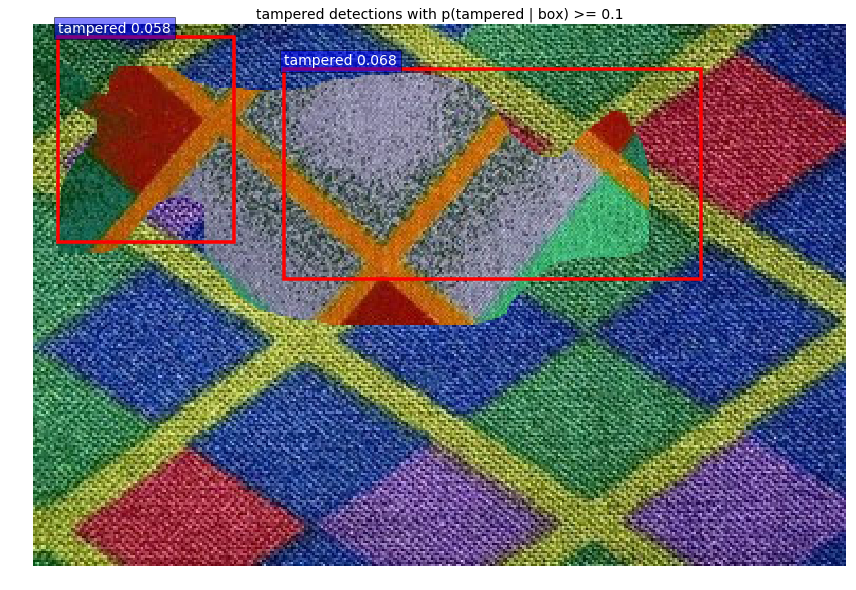

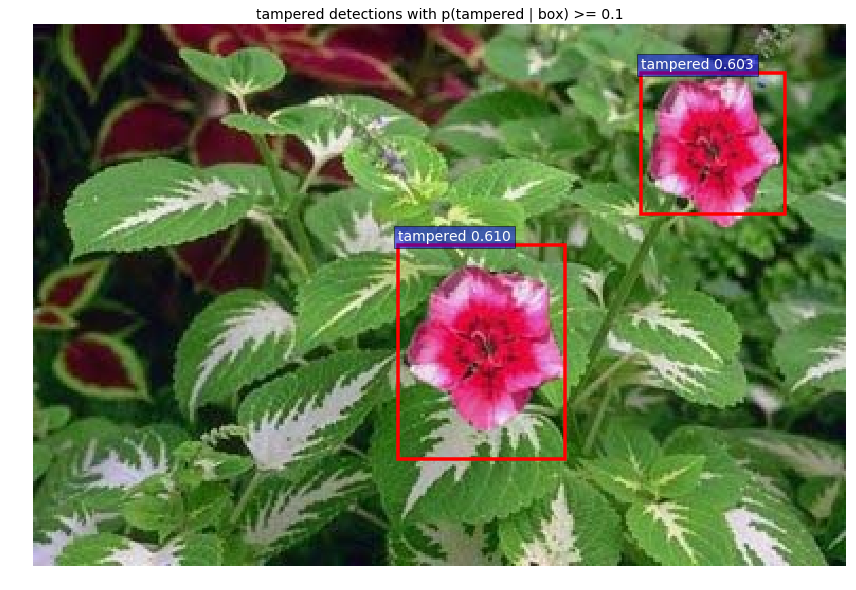

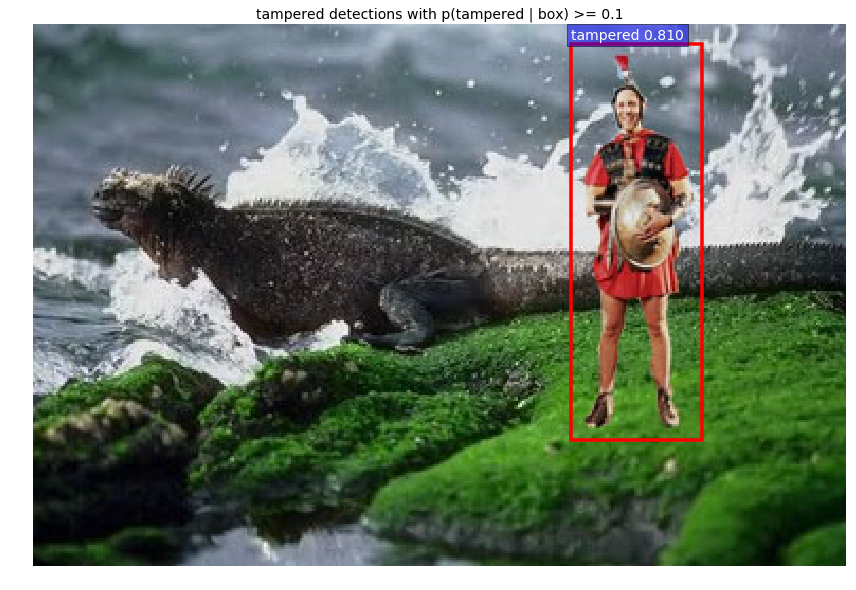

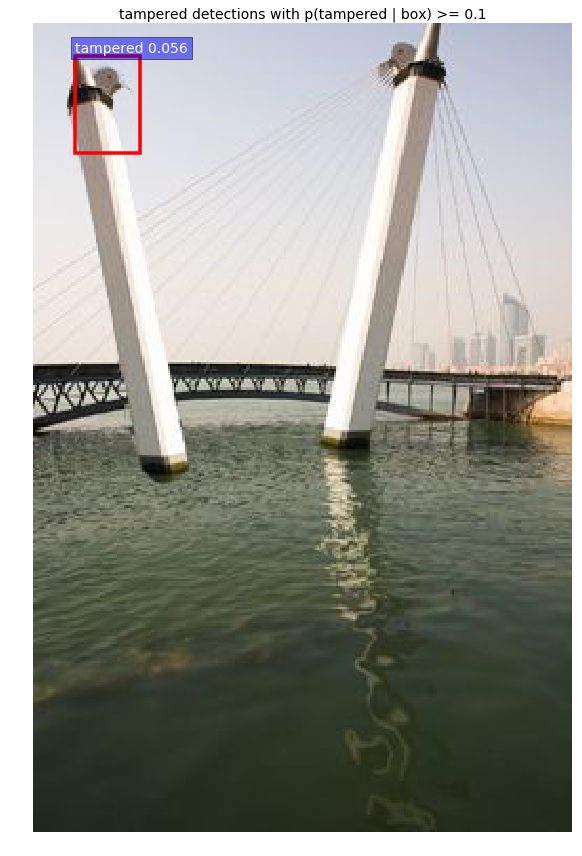

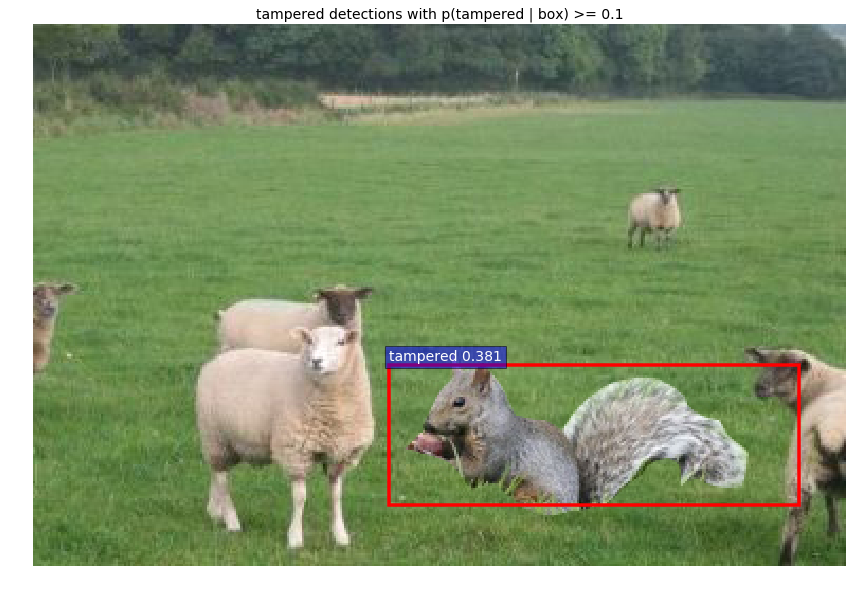

In [5]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------


"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lib.config import config as cfg
from lib.utils.nms_wrapper import nms
from lib.utils.test import im_detect
#from nets.resnet_v1 import resnetv1
from lib.nets.vgg16rgb import vgg16
from lib.utils.timer import Timer
# tf.app.flags.DEFINE_string('f', '', 'kernel')
CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_rgb_iter_4000.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}
tf.get_variable_scope().reuse_variables()
tf.reset_default_graph()

def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_400.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_400.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.674s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.528s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.537s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.599s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.545s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jp

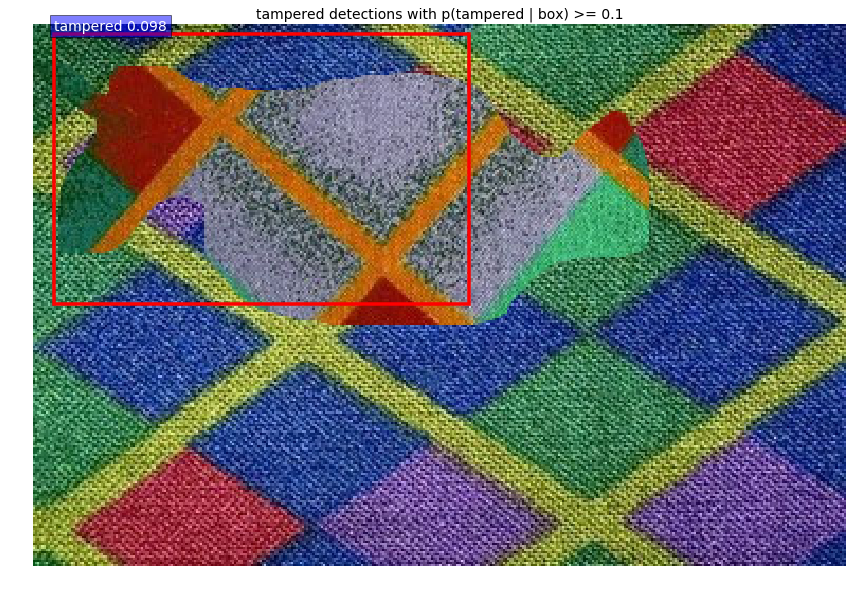

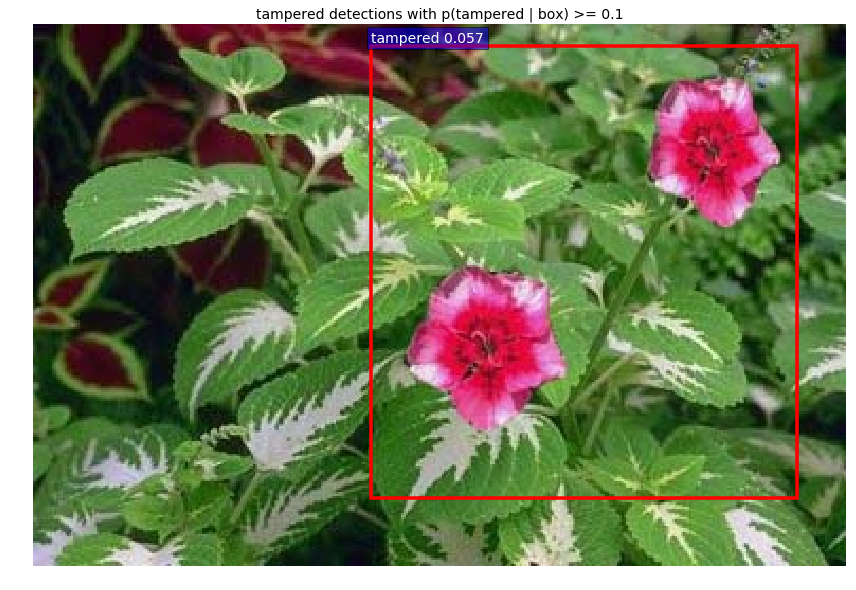

In [14]:

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_rgb_iter_400.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}
tf.get_variable_scope().reuse_variables()
tf.reset_default_graph()

def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_1000.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_1000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.609s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.560s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.555s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.535s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.599s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.

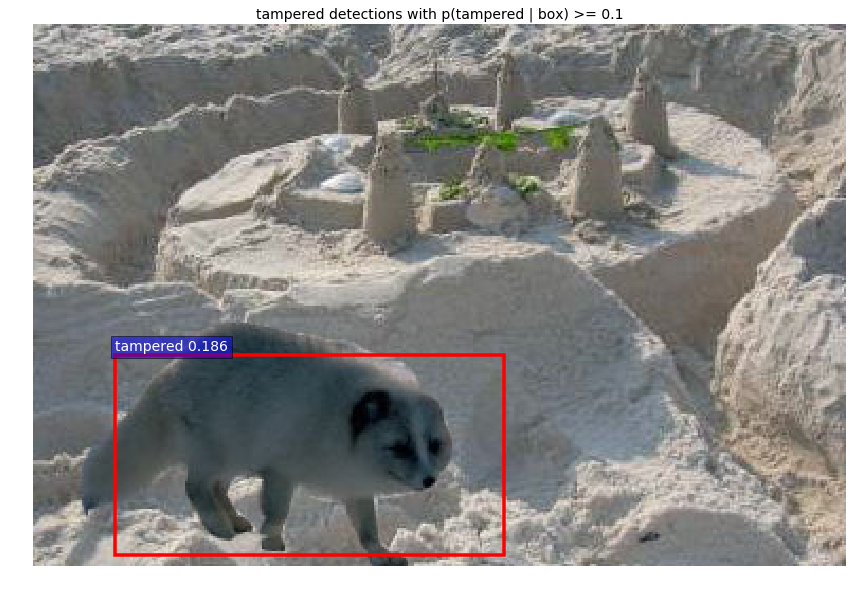

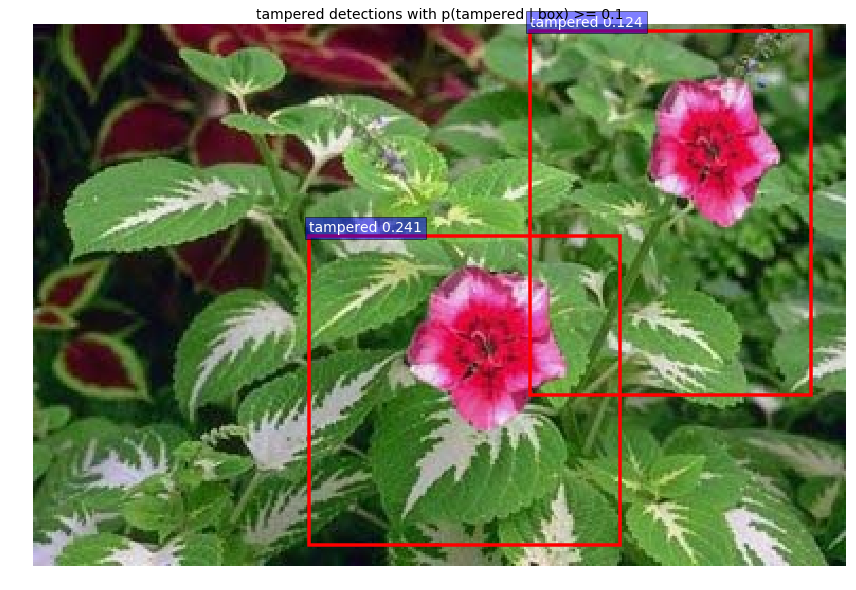

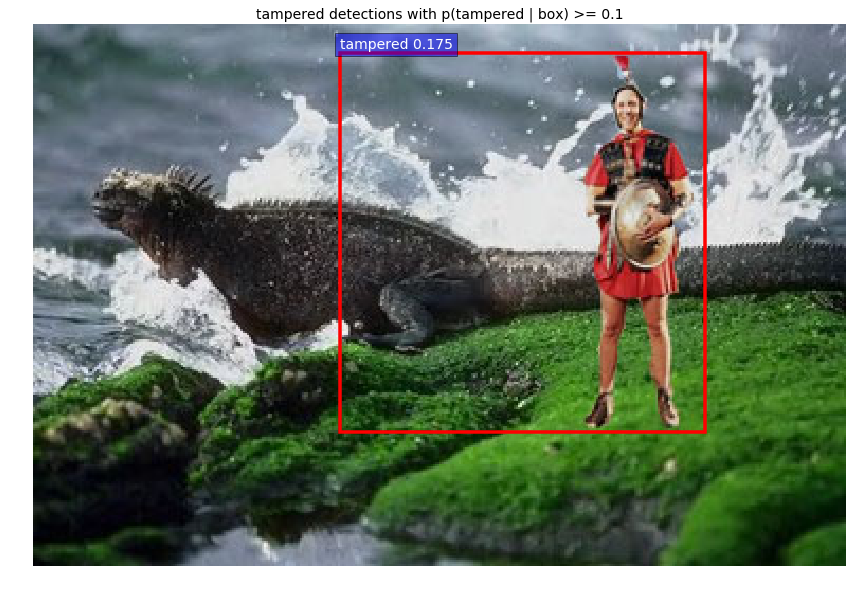

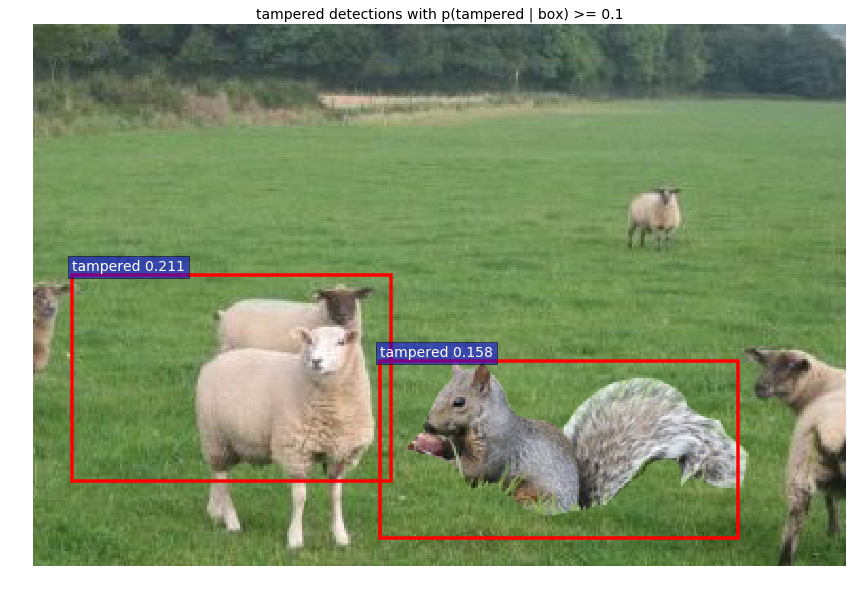

In [8]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_rgb_iter_1000.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.1
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_500.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_rgb_iter_500.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.611s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.611s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.551s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.577s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.555s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0427.jp

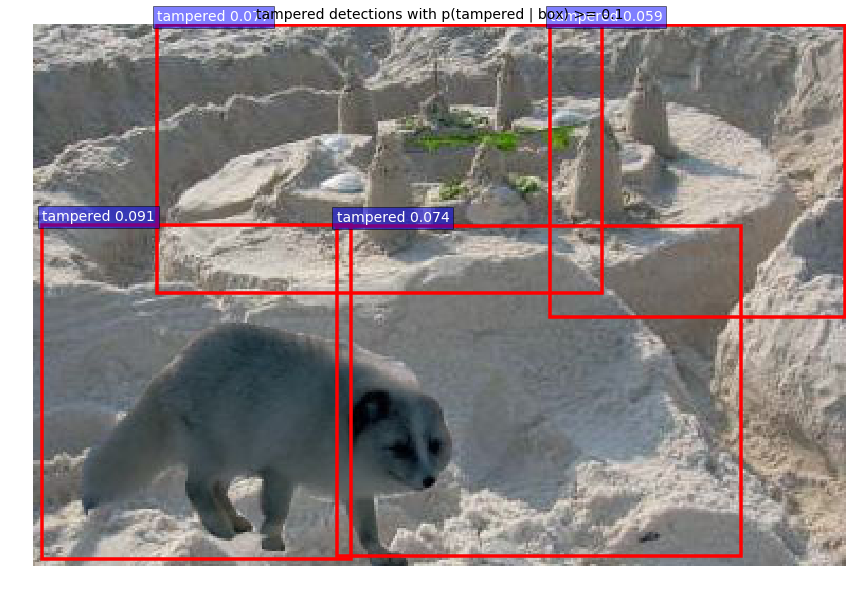

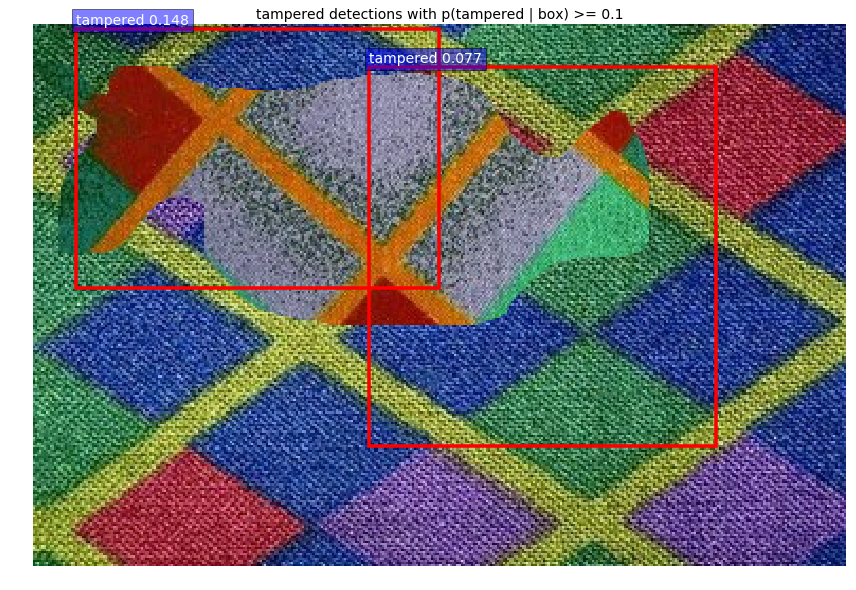

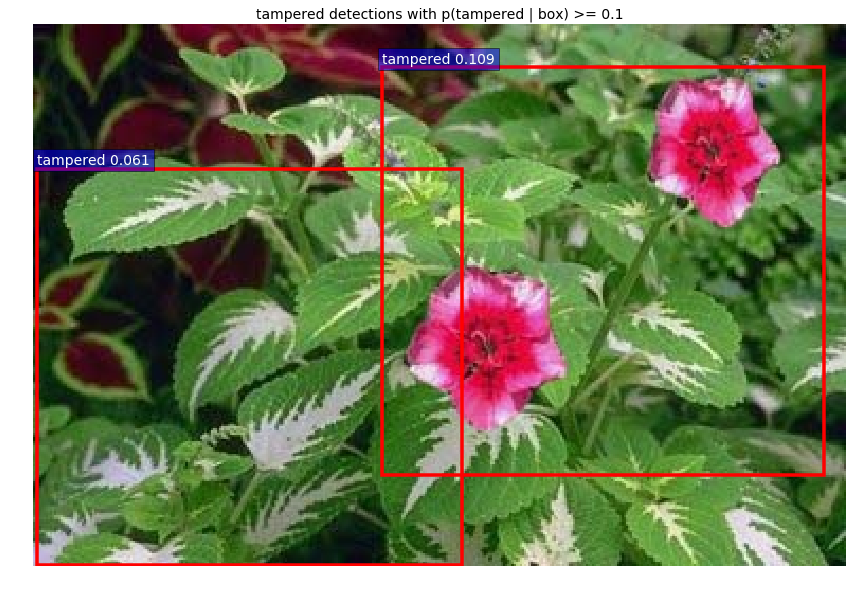

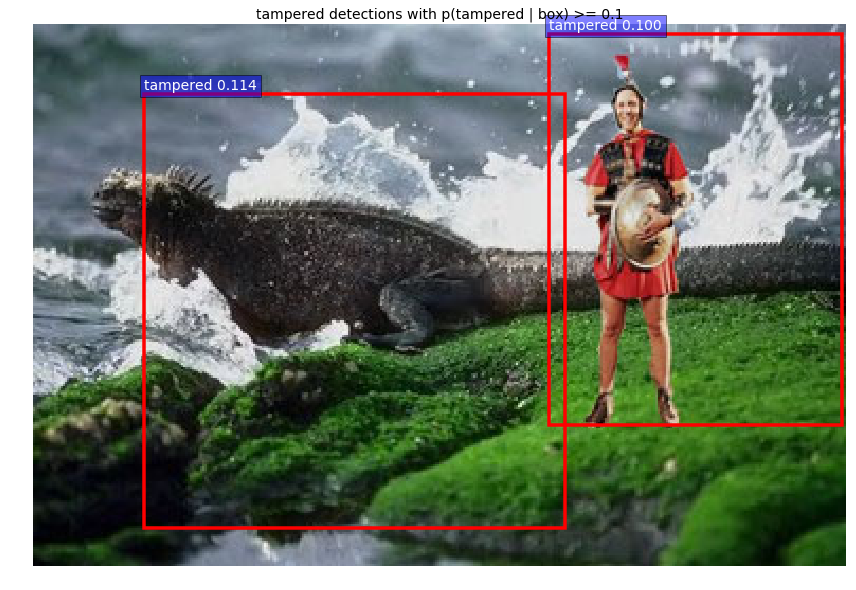

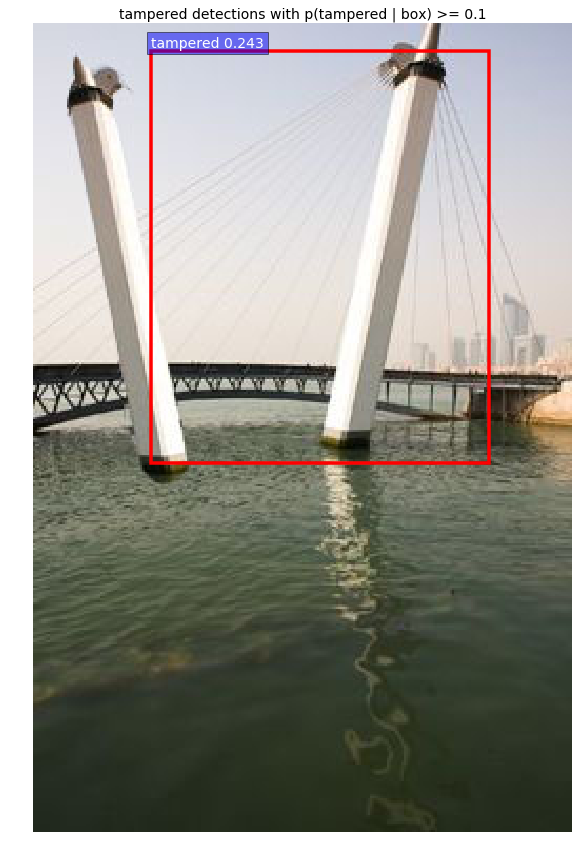

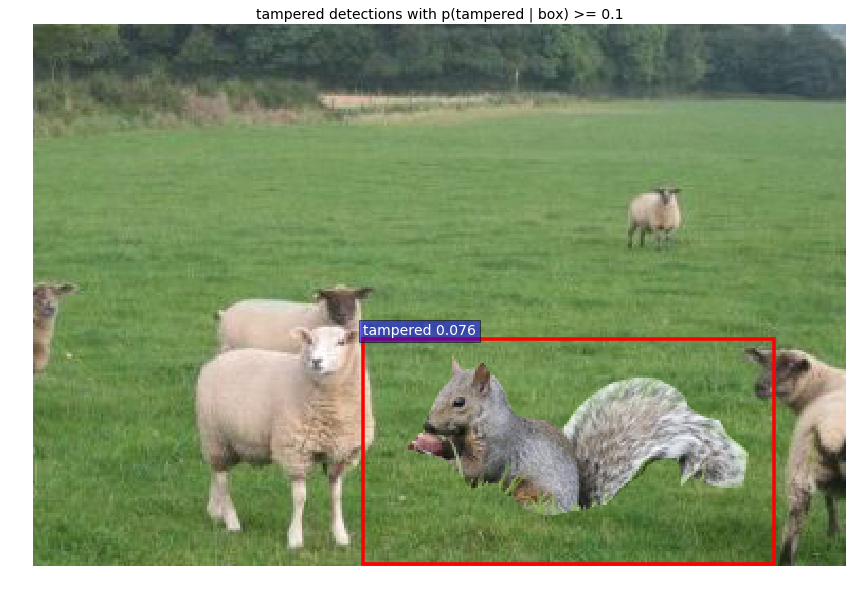

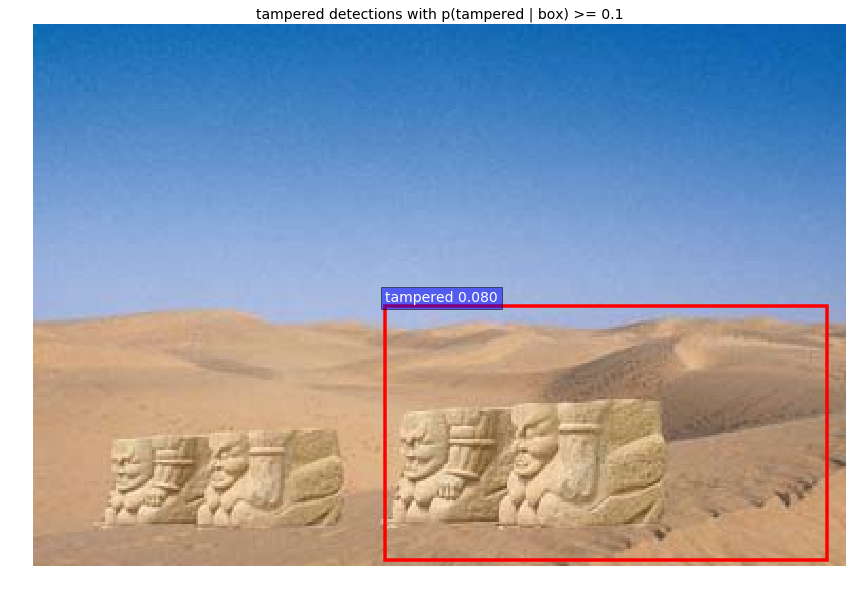

In [9]:

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_rgb_iter_500.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}
tf.get_variable_scope().reuse_variables()
tf.reset_default_graph()

def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()